#### Playing around with the MUSE Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = "./data/MuseData/MU.txt"
df = pd.read_csv(data_path, sep='\t', header=None, names=['id', 'stim_id', 'source', 'channel', 'col5', 'n_samples', 'samples'])

In [ ]:
df.head()

,id,stim_id,source,channel,col5,n_samples,samples
0,978111,132669,MU,TP9,6,459,"475,474,477,486,486,476,479,483,489,483,482,48..."
1,978112,132669,MU,FP1,6,459,"468,487,493,493,498,493,491,490,492,487,483,48..."
2,978113,132669,MU,FP2,6,459,"482,475,490,500,485,470,470,482,490,484,478,48..."
3,978114,132669,MU,TP10,6,459,"470,470,478,489,487,475,469,478,488,483,474,48..."
4,978115,132670,MU,TP9,7,493,"506,499,495,491,492,507,496,500,498,496,499,50..."


In [35]:
# source column is unnecessary
df = df.drop('source', axis=1)

In [37]:
df.head()

,id,stim_id,channel,col5,n_samples,samples
0,978111,132669,TP9,6,459,"[475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479..."
1,978112,132669,FP1,6,459,"[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491..."
2,978113,132669,FP2,6,459,"[482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470..."
3,978114,132669,TP10,6,459,"[470.0, 470.0, 478.0, 489.0, 487.0, 475.0, 469..."
4,978115,132670,TP9,7,493,"[506.0, 499.0, 495.0, 491.0, 492.0, 507.0, 496..."


In [ ]:
df.isna().any().any()   # No NaN values across the entire df, good
# TODO: Also see df.isna().sum().sum() and df[df.isna().any(axis=1)]

False

In [ ]:
print(type(df['samples'].iloc[0]))   # is str
# need to convert into array

# *Imp use case:
df['samples'] = df['samples'].apply(lambda x: np.array(list(map(float, x.split(',')))))
# TODO: See .apply(), .applymap(), and .map()

In [ ]:
# just confirming that the column 5 is n_samples itself
a = (df['samples'].apply(len)).to_numpy()
b = df['n_samples'].to_numpy()
c = np.array([a==b])
print(c.sum())
print(len(b))

163932
163932


In [10]:
df['n_samples'].describe()

count    163932.000000
mean        468.399654
std          16.085971
min         408.000000
25%         459.000000
50%         460.000000
75%         476.000000
max         612.000000
Name: n_samples, dtype: float64

Clearly, mean length is 468.4, min is 408, and max is 612
We need to try and get all values to a median value

Note: In neuroscience and related data, 'EPOCH' means a short time-interval of continuous (EEG) data associated with a specific event or stimulus
NOT related to deep learning epoch.

In [50]:
grouped = df.groupby('stim_id')
# basically this returns an iterator, which contains groups of all rows that have the same stim_id

# ex:
for stim_id, group in grouped:
    print(stim_id)
    print(group.head())
    break

132669
       id  stim_id channel  col5  n_samples  \
0  978111   132669     TP9     6        459   
1  978112   132669     FP1     6        459   
2  978113   132669     FP2     6        459   
3  978114   132669    TP10     6        459   

                                             samples  
0  [475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479...  
1  [468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...  
2  [482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470...  
3  [470.0, 470.0, 478.0, 489.0, 487.0, 475.0, 469...  


In [56]:
# calculate the median length
median = int(df['samples'].apply(len).median())
median

460

#### Visualising linear interpolation for the first stimulus

In [78]:
# first, plotting the current data for the first stimulus
channel_names = df[:4]['channel'].tolist()
ch1 = np.array(df[:4]['samples'][0].tolist())
ch2 = np.array(df[:4]['samples'][1].tolist())
ch3 = np.array(df[:4]['samples'][2].tolist())
ch4 = np.array(df[:4]['samples'][3].tolist())
channel_signals = np.vstack([ch1, ch2, ch3, ch4])

In [79]:
channel_signals.shape

(4, 459)

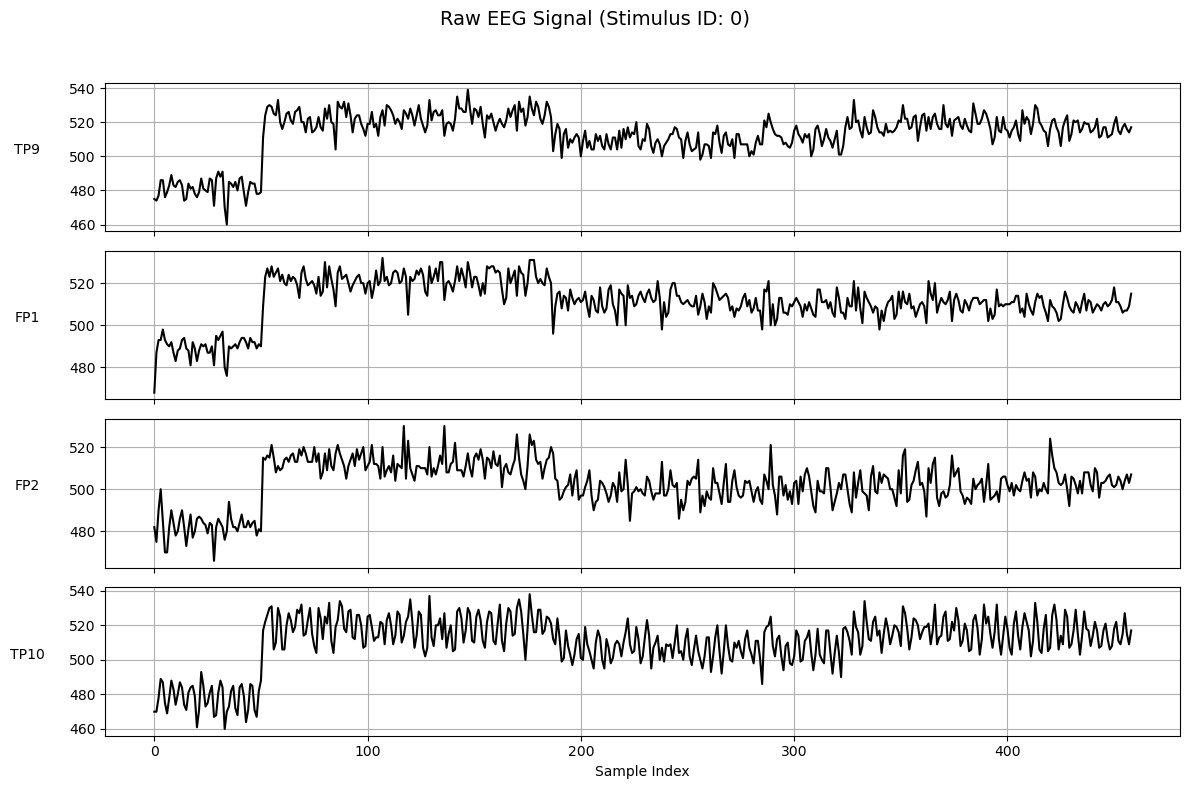

In [102]:
# RAW Data (non-interpolated)
fig, axs = plt.subplots(len(channel_signals), 1, figsize=(12, 8), sharex=True)

for i, (ax, signal) in enumerate(zip(axs, channel_signals)):
    ax.plot(signal, color='black')
    ax.set_ylabel(channel_names[i], rotation=0, labelpad=30, fontsize=10)
    ax.grid(True)

plt.suptitle(f"Raw EEG Signal (Stimulus ID: 0)", fontsize=14)
plt.xlabel("Sample Index")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [94]:
from scipy.interpolate import interp1d

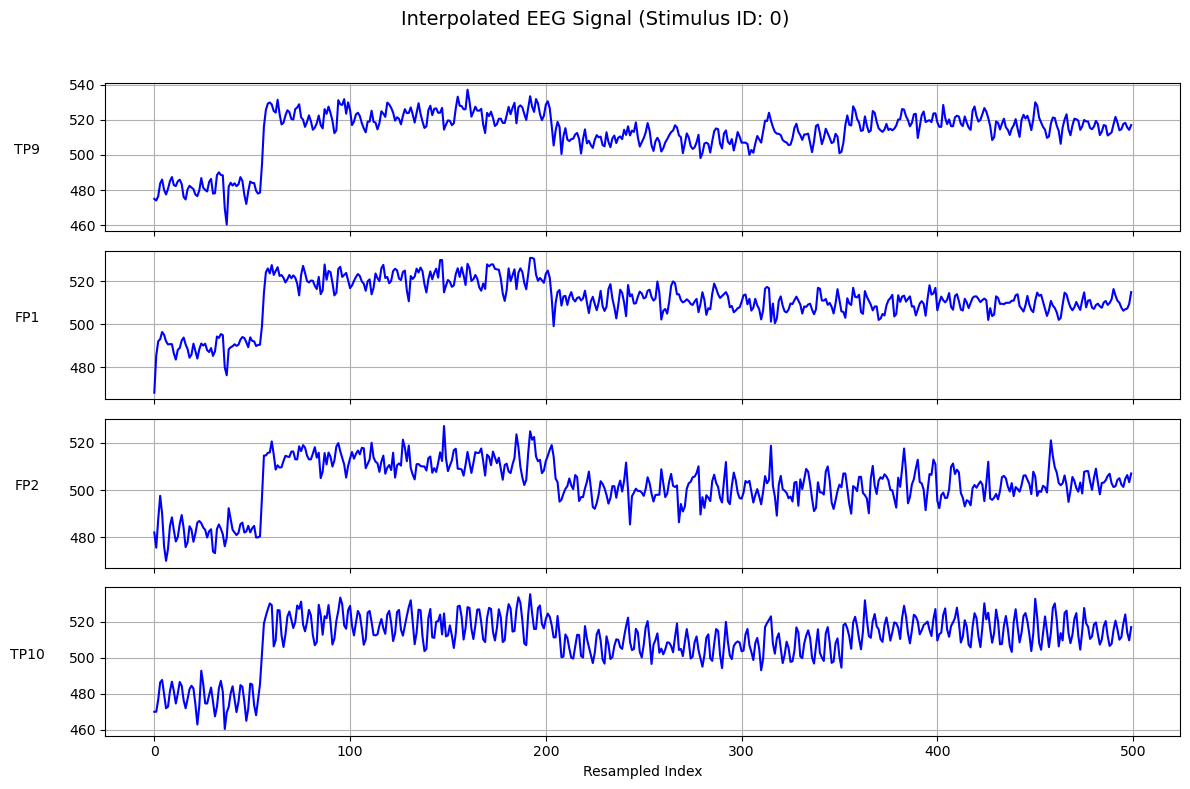

In [95]:
interpolated_signals = []
target_len = 500
for signal in channel_signals:
    x_original = np.linspace(0, 1, len(signal))
    x_target = np.linspace(0, 1, target_len)
    interpolator = interp1d(x_original, signal, kind='linear')
    interpolated_signal = interpolator(x_target)
    interpolated_signals.append(interpolated_signal)

# Step 4: Plot each interpolated signal in separate strips
fig, axs = plt.subplots(len(interpolated_signals), 1, figsize=(12, 8), sharex=True)

for i, (ax, signal) in enumerate(zip(axs, interpolated_signals)):
    ax.plot(signal, color='blue')
    ax.set_ylabel(channel_names[i], rotation=0, labelpad=30, fontsize=10)
    ax.grid(True)

plt.suptitle(f"Interpolated EEG Signal (Stimulus ID: 0)", fontsize=14)
plt.xlabel("Resampled Index")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

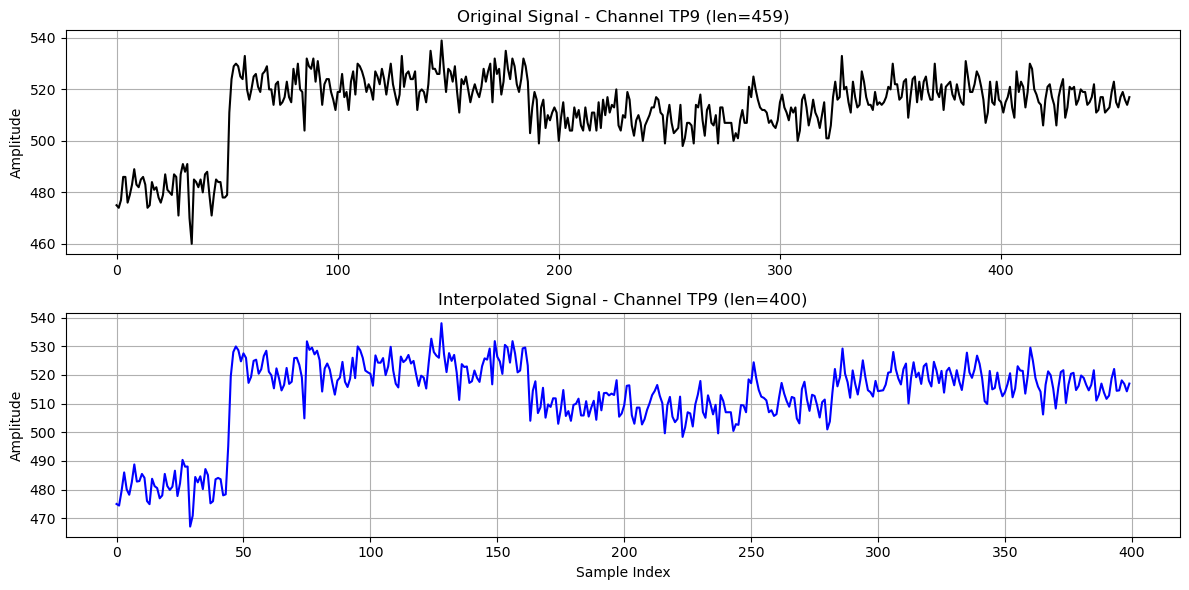

In [101]:
signal = channel_signals[0]

# Interpolation step
original_len = len(signal)
target_len = 400
x_original = np.linspace(0, 1, original_len)
x_target = np.linspace(0, 1, target_len)
interpolator = interp1d(x_original, signal, kind='linear')
interpolated_signal = interpolator(x_target)

# Plot both
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

axs[0].plot(signal, color='black')
axs[0].set_title(f"Original Signal - Channel TP9 (len={original_len})")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

axs[1].plot(interpolated_signal, color='blue')
axs[1].set_title(f"Interpolated Signal - Channel TP9 (len={target_len})")
axs[1].set_ylabel("Amplitude")
axs[1].set_xlabel("Sample Index")
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Performing Linear Interpolation on all the data

In [107]:
for id, group in grouped:
    print(group['samples'])
    break

0    [475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479...
1    [468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...
2    [482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470...
3    [470.0, 470.0, 478.0, 489.0, 487.0, 475.0, 469...
Name: samples, dtype: object


In [110]:
median_len = int(df['samples'].apply(len).median())
median_len

460

In [111]:
final_epochs = []

for id, group in grouped:
    if (len(group['channel']) != 4):
        print(f"Not right channels, stim id: {id}")
        continue
    
    interpolated = []
    for signal in group['samples']:
        original_len = len(signal)
        x_original = np.linspace(0, 1, original_len)
        x_target = np.linspace(0, 1, median_len)
        interpolator = interp1d(x_original, signal, kind='linear')
        interpolated_signal = interpolator(x_target)
        interpolated.append(interpolated_signal)
    
    interpolated = np.array(interpolated)
    final_epochs.append(interpolated)

final_epochs = np.array(final_epochs)

In [ ]:
final_epochs.shape
# this is our final data divided into epochs and made into median length

(40983, 4, 460)

In [114]:
# saving the array for future use
file_path = './cleaned_data/data.npy'

np.save(file_path, final_epochs)